# Policy analysis
The point of this notebook is to analyze the privacy policies fetched with the spider.  
This presumes all the policies that are marked as successfully gathered in the report file are good, and only looks at said policies

In [149]:
import os
import json
import justext
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import langid

In [150]:
def site_name_from_file_name(file_name):
    return file_name[len("policy_"):len(file_name) - 4]

In [151]:
def make_policy_files():
    policy_files = []
    for filename in policy_file_names:
        policy_files.append(open(DATADIR + filename))
    return policy_files

## 1 Overview

In [152]:
DATADIR = "data/"
POLICY_FILE_PREFIX = "policy_"
REPORT_FILE_NAME = "crawl_report.json"

In [153]:
report_json = pd.read_json(DATADIR + REPORT_FILE_NAME)
report_json

,url,policy_domain,policy_url,policy_file,uses_iubenda,success
0,https://www.google.com/,www.google.com,https://www.google.com/intl/it/policies/privacy/,policy_www.google.com.txt,False,True
1,https://twitter.com,twitter.com,https://twitter.com/privacy,policy_twitter.com.txt,False,True
2,https://www.youtube.com/,www.youtube.com,https://www.youtube.com/t/privacy,policy_www.youtube.com.txt,False,True
3,https://www.microsoft.com/it-it/,privacy.microsoft.com,https://privacy.microsoft.com/it-it,policy_www.microsoft.com.txt,False,True
4,https://www.wikipedia.org/,meta.wikimedia.org,https://meta.wikimedia.org/wiki/Privacy_policy,policy_www.wikipedia.org.txt,False,True
...,...,...,...,...,...,...
354,https://www.trendyol.com/,None,None,policy_www.trendyol.com.txt,False,False
355,https://www.americanexpress.com/it-it/,www.americanexpress.com,https://www.americanexpress.com/it-it/chi-siam...,policy_www.americanexpress.com.txt,False,True
356,https://www.fedex.com/,None,None,policy_www.fedex.com.txt,False,False
357,https://www.oreilly.com/,www.oreilly.com,https://www.oreilly.com/privacy.html,policy_www.oreilly.com.txt,False,True


### 1.1 Success rate

In [154]:
# Recap
number_total = len(report_json)
print("Analyzed sites: " + str(number_total))

successful = report_json.loc[report_json["success"] == True]
number_successful = len(successful)
print("Successfully downloaded: " + str(number_successful))

print("Success rate: " + str(round((100 * number_successful / number_total), 1)) + "%")

failed_with_url = report_json.loc[pd.notna(report_json["policy_url"])
                                  & (report_json["success"] == False)]
print("Policy url found but no good policy found: " + str(len(failed_with_url)))
failed_with_url

Analyzed sites: 359
Successfully downloaded: 280
Success rate: 78.0%
Policy url found but no good policy found: 0


,url,policy_domain,policy_url,policy_file,uses_iubenda,success


### 1.2 Sites overview

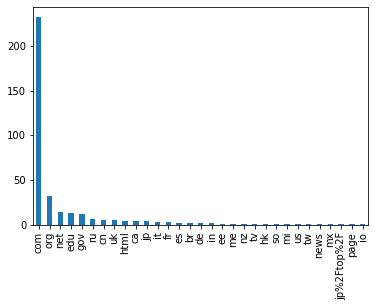

In [155]:
# TLDs

urls = report_json["url"]
ul = urls.tolist()

tlds = {}
for url in ul:
    tld = ((url.split(".")[len(url.split(".")) - 1]).split("/")[0]).split(":")[0]
    if tld in tlds.keys():
        tlds[tld] = tlds[tld] + 1
    else:
        tlds[tld] = 1
        
pd.Series(tlds).sort_values(ascending = False).plot.bar()
plt.show()

## 2 Simple analysis

In [156]:
# Open policy files
policy_file_names = successful["policy_file"].tolist()

### 2.1 Language detection

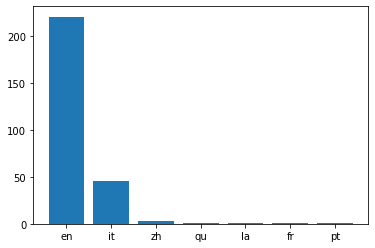

In [157]:
# Language detection
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))


languages = {}
for file in policy_files:
    languages[file.name] = langid.classify(file.read())[0]

plt.bar(pd.Series(languages).value_counts().keys(), pd.Series(languages).value_counts())
plt.show()

### 2.2 Wordcounts

en
221 total policies


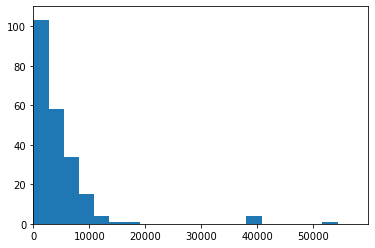

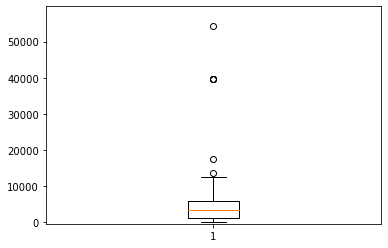

it
46 total policies


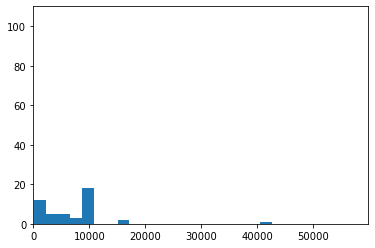

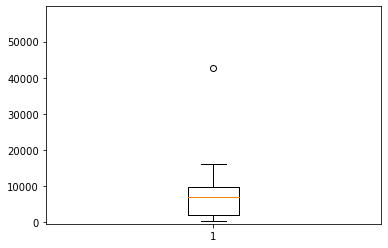

zh
3 total policies
Sample size for zh too small
qu
1 total policies
Sample size for qu too small
la
1 total policies
Sample size for la too small
fr
1 total policies
Sample size for fr too small
pt
1 total policies
Sample size for pt too small


In [163]:
# Simple analysis i.e. wordcount

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

highest_wordcount = 0
for file in policy_files:
    file_wordcount = len(file.read().split())
    if file_wordcount > highest_wordcount:
        highest_wordcount = file_wordcount

    
for language in pd.Series(languages).value_counts().keys():
    policy_files = []
    for filename in languages.keys():
        if languages[filename] == language:
            filename = filename[len("data/"):]
            policy_files.append(open(DATADIR + filename))
    
    print(language)
    total_policies_current_language = len(policy_files)
    print(str(total_policies_current_language) + " total policies")
    if total_policies_current_language < 10: # Ignore small sample sizes
        print("Sample size for " + language + " too small")
        continue
    
    wordcounts = []
    for file in policy_files:
        wordcounts.append(len(file.read().split()))

#     plt.ylim(0, 15)
    plt.ylim(0, 110)
    plt.xlim(0, highest_wordcount * 1.1)
    plt.hist(wordcounts, 20)
    plt.show()
    
    plt.ylim(-(highest_wordcount / 100), highest_wordcount * 1.1)
    plt.boxplot(wordcounts)
    plt.show()

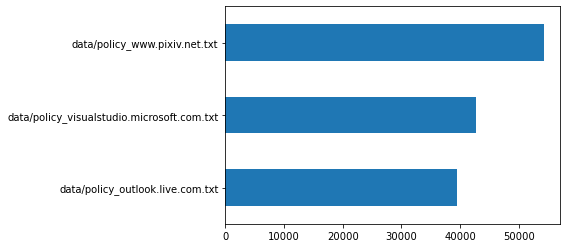

In [159]:
# Top 3 longest policies by wordcount overall

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

wc_dict = {}

for file in policy_files:
    wc_dict[file.name] = len(file.read().split())
    
wc_s = pd.Series(wc_dict).sort_values(ascending=True)
wc_s[len(wc_s) - 3:].plot.barh()
plt.show()

In [160]:
wc_s[len(wc_s) - 3:]

data/policy_outlook.live.com.txt              39532
data/policy_visualstudio.microsoft.com.txt    42626
data/policy_www.pixiv.net.txt                 54348
dtype: int64

### 2.3 Wordclouds

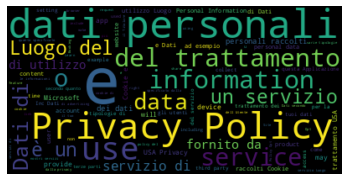

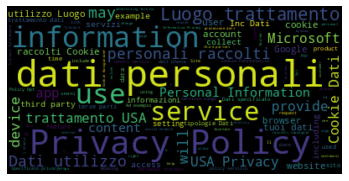

In [23]:
# Some fun wordclouds :)
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

all_policy_text = ""
for file in policy_files:
    all_policy_text += file.read()

wordcloud = WordCloud().generate(all_policy_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Unsurprisingly you have to filter out heaps of words...
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

all_policy_text_filtered = ""
for file in policy_files:
    for word in file.read().split():
        if word not in (justext.get_stoplist("Italian")):
            all_policy_text_filtered += word + " "

wordcloud = WordCloud().generate(all_policy_text_filtered)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.4 Emotion analysis

In [11]:
# Text2Emotion
import text2emotion as t2e
import emoji
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
emotions_dict = {
    "Angry" : 0,
    "Fear" : 0,
    "Happy" : 0,
    "Sad" : 0,
    "Surprise" : 0
}

In [18]:
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

In [19]:
for file in policy_files:
    emotions = t2e.get_emotion(file.read())
    top_emotion = max(emotions)
    emotions_dict[top_emotion] = emotions_dict[top_emotion] + 1

emotions_dict

{'Angry': 0, 'Fear': 0, 'Happy': 0, 'Sad': 0, 'Surprise': 65}

In [21]:
emotions_dict = {
    "Angry" : 0,
    "Fear" : 0,
    "Happy" : 0,
    "Sad" : 0,
    "Surprise" : 0
}

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

for file in policy_files:
    emotions = t2e.get_emotion(file.read())
    for emotion in emotions:
        emotions_dict[emotion] = emotions_dict[emotion] + emotions[emotion] # maybe normalize?

emotions_dict

{'Angry': 1.7400000000000007,
 'Fear': 40.48000000000001,
 'Happy': 7.440000000000001,
 'Sad': 10.629999999999995,
 'Surprise': 4.679999999999999}

In [22]:
for e in emotions_dict.keys():
    emotions_dict[e] = round(emotions_dict[e] / len(policy_files), 3)

emotions_dict

{'Angry': 0.027,
 'Fear': 0.623,
 'Happy': 0.114,
 'Sad': 0.164,
 'Surprise': 0.072}

### 2.5 Text clustering

In [164]:
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

policy_texts = []

for file in policy_files:
    policy_texts.append(file.read())

df = pd.DataFrame(data = policy_texts, columns = ["Text"])
df

,Text
0,Privacy e termini Accedi Introduzione Norme su...
1,Skip to main content Privacy Policy Twitter Pr...
2,Privacy e termini Accedi Introduzione Norme su...
3,Passa a contenuti principali Microsoft Privacy...
4,"Privacy policy From Meta, a Wikimedia project ..."
...,...
275,Skip to main content An official website of th...
276,Privacy e termini Privacy e termini Accedi Int...
277,Skip to content MenuMenu Il seguente elemento ...
278,Skip to main content Sign In Try Now Teams For...


In [165]:
# There should be a separation based on the policy's language

from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words = "english", ngram_range = (1, 3))
vec.fit(df.Text.values)
features = vec.transform(df.Text.values)

In [166]:
from sklearn.cluster import MiniBatchKMeans, KMeans
clust = KMeans(init = "k-means++", n_clusters = 2, n_init = 10)

clust.fit(features)
yhat = clust.predict(features)
df['Cluster Labels'] = clust.labels_

# df.loc[df["Cluster Labels"] == 1]

In [167]:
df_similar = pd.DataFrame(df.loc[df["Cluster Labels"] == 1].values)
# df_similar

In [168]:
df_dissimilar = pd.DataFrame(df.loc[df["Cluster Labels"] == 0].values)
# df_dissimilar

In [169]:
langs = pd.Series(languages).unique()

for lang in langs:
    print(lang)

it
en
zh
qu
la
fr
pt


In [276]:
for lang in langs:
    language = ""
    
    if lang == "it":
        language = "italian"
    elif lang == "en":
        language = "english"
    else:
        break
        
    print("Current language: " + lang)

#     texts_in_lang = {}

    df_texts_in_lang = pd.DataFrame(columns = ["Text"])
    
    for file in make_policy_files():
        file_text = file.read()
        file_lang = langid.classify(file_text)[0]
        if file_lang == lang:
#             texts_in_lang.append(file_text)
#             texts_in_lang[file.name] = file_text
#             print(df_texts_in_lang)
#             df_texts_in_lang = df_texts_in_lang.append([file.name, file_text])
            df_texts_in_lang.loc[file.name] = file_text
    
#     print(texts_in_lang)
    
#     df_texts_in_lang = pd.DataFrame(data = texts_in_lang, columns = ["Filename", "Text"])
    
    
    from sklearn.decomposition import TruncatedSVD
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import Normalizer

    lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))


    vectorizer = TfidfVectorizer(
        max_df=0.5,
        min_df=5,
#         stop_words="english",
    )

    try:
        X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)
    except ValueError:
        continue
    
    X_lsa = lsa.fit_transform(X_tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()


    kmeans = KMeans(
        n_clusters=2,
        max_iter=100,
        n_init=1,
    )

    kmeans.fit(X_lsa)

    original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(2):
        print(f"Cluster {i}: ", end="")
        for ind in order_centroids[i, :10]:
            print(f"{terms[ind]} ", end="")
        print()

Current language: it
Cluster 0: youtube risultati gmail esaminare vai android play identificatori chrome inserzionisti 
Cluster 1: microsoft terzi piattaforma to mail social media business proprio and 
Current language: en
Cluster 0: amazon university gov statement microsoft resources wikimedia disney health copyright 
Cluster 1: california shield categories profile ccpa legitimate apps platform uk advertisements 


In [277]:
df_texts_in_lang

,Text
data/policy_twitter.com.txt,Skip to main content Privacy Policy Twitter Pr...
data/policy_www.wikipedia.org.txt,"Privacy policy From Meta, a Wikimedia project ..."
data/policy_outlook.live.com.txt,Skip to main content Microsoft Privacy Privacy...
data/policy_github.com.txt,Skip to main content GitHub Docs All products ...
data/policy_wordpress.org.txt,Skip to content Log In Register WordPress.org ...
...,...
data/policy_wpengine.com.txt,Skip to content WP Engine Products Resources W...
data/policy_www.frontiersin.org.txt,Skip to main content Navigation Top bar naviga...
data/policy_www.irs.gov.txt,Skip to main content An official website of th...
data/policy_www.oreilly.com.txt,Skip to main content Sign In Try Now Teams For...


In [278]:
# df_texts_in_lang["Text"].index[2]

#### DBSCAN

In [297]:
from sklearn.cluster import DBSCAN

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
)


texts_in_lang = []

for file in make_policy_files():
    file_text = file.read()
#     file_lang = langid.classify(file_text)[0]
#     if file_lang == lang:
    texts_in_lang.append(file_text)

# df_texts_in_lang = pd.DataFrame(data = texts_in_lang, columns = ["Text"])

# --

X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)

X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

X = X_lsa

db = DBSCAN(eps=1, min_samples=len(df_texts_in_lang) // 10).fit(X) # each cluster must contain at lesast 1/10th of the total
# db.labels_

In [315]:
db_df = pd.DataFrame(data = {"Cluster" : db.labels_,
                             "Text" : df_texts_in_lang.Text},
#                              "Filename" : df_texts_in_lang.index},
                     index = df_texts_in_lang.index)
db_df

,Cluster,Text
data/policy_twitter.com.txt,0,Skip to main content Privacy Policy Twitter Pr...
data/policy_www.wikipedia.org.txt,0,"Privacy policy From Meta, a Wikimedia project ..."
data/policy_outlook.live.com.txt,0,Skip to main content Microsoft Privacy Privacy...
data/policy_github.com.txt,-1,Skip to main content GitHub Docs All products ...
data/policy_wordpress.org.txt,0,Skip to content Log In Register WordPress.org ...
...,...,...
data/policy_wpengine.com.txt,-1,Skip to content WP Engine Products Resources W...
data/policy_www.frontiersin.org.txt,-1,Skip to main content Navigation Top bar naviga...
data/policy_www.irs.gov.txt,-1,Skip to main content An official website of th...
data/policy_www.oreilly.com.txt,0,Skip to main content Sign In Try Now Teams For...


In [299]:
db_df.loc[db_df["Cluster"] == -1] # Dissimilar entries

,Cluster,Text,Filename
data/policy_github.com.txt,-1,Skip to main content GitHub Docs All products ...,data/policy_github.com.txt
data/policy_www.apple.com.txt,-1,Global Nav Open MenuGlobal Nav Close Menu Appl...,data/policy_www.apple.com.txt
data/policy_wordpress.com.txt,-1,Automattic Home About Us News Work With Us Pri...,data/policy_wordpress.com.txt
data/policy_bitly.com.txt,-1,Skip Navigation Get the tools to grow with Sta...,data/policy_bitly.com.txt
data/policy_www.nih.gov.txt,-1,Skip to main content An official website of th...,data/policy_www.nih.gov.txt
...,...,...,...
data/policy_www.ea.com.txt,-1,Electronic Arts Home\nFeatured GamesAll GamesC...,data/policy_www.ea.com.txt
data/policy_www.newyorker.com.txt,-1,Skip to main content About Brands Stores Comme...,data/policy_www.newyorker.com.txt
data/policy_wpengine.com.txt,-1,Skip to content WP Engine Products Resources W...,data/policy_wpengine.com.txt
data/policy_www.frontiersin.org.txt,-1,Skip to main content Navigation Top bar naviga...,data/policy_www.frontiersin.org.txt


In [300]:
# import matplotlib.pyplot as plt

# # Black removed and is used for noise instead.
# labels = [0, -1]
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = labels == k
    
#     xy = X[class_member_mask & core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=14,
#     )

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=6,
#     )

# plt.title("Estimated number of clusters: %d" % n_clusters_)
# plt.show()

#### 2.5.2 Finer Clustering

In [301]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(features)

def getind(c):
    return df[df.Text == c].index.tolist()

def gettext(i):
    return df[df.index == i].Text.tolist()

In [302]:
similar = list(enumerate(cosine_sim[0]))
# similar

In [303]:
# This one kinda does the same thing as the 2 clusters

sim_list = []
unsim_list = []
for m in similar:
    t = gettext(m[0])
    if m[1] > 0.15:
        sim_list.append(t)
    else:
        unsim_list.append(t)

In [304]:
df_sim = pd.DataFrame(sim_list, columns = ["Text"])
df_unsim = pd.DataFrame(unsim_list, columns = ["Text"])

In [305]:
# df_sim

In [306]:
# df_unsim

In [307]:
cosim = list(enumerate(cosine_sim))
cumulative_sim = []

for entry in cosim:
    cumulative_sim.append(0)

for entry in cosim:
    i = 0
    for sim_value in entry[1]:
        cumulative_sim[i] = cumulative_sim[i] + (sim_value / len(cosim)) # Normalization
        
        i = i + 1

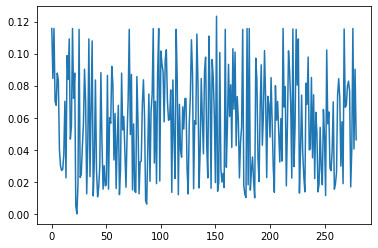

In [308]:
plt.plot(cumulative_sim)

In [309]:
sim_list = []
unsim_list = []

threshold = 0.085

i = 0
for k in cumulative_sim:
    t = gettext(i)
    if k > threshold:
        sim_list.append(t)
    else:
        unsim_list.append(t)
    i = i + 1

In [310]:
df_sim = pd.DataFrame(sim_list, columns = ["Text"])
df_unsim = pd.DataFrame(unsim_list, columns = ["Text"])

In [311]:
# df_sim

In [312]:
# df_unsim

In [313]:
verysim_list = []

threshold = 0.185

i = 0
for k in cumulative_sim:
    t = gettext(i)
    if k > threshold:
        verysim_list.append(t)
#     else:
#         unsim_list.append(t)
    i = i + 1

In [314]:
df_verysim = pd.DataFrame(verysim_list, columns = ["Text"])
df_verysim

,Text
